In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import layers

# STN

In [2]:
def build_localization_network(inp_shape):
    input = layers.Input(shape = inp_shape)

    x = layers.Conv2D(32, kernel_size = 7, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(input)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, kernel_size = 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.Dropout(0.4)(x)
    
    theta = layers.Dense(3 * 2, activation=None,
                         kernel_initializer=tf.keras.initializers.Zeros(),
                         bias_initializer=tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0]))(x)
    
    return tf.keras.Model(input, theta, name = 'LocalizationNetwork')

In [3]:
class spatialTransformer(tf.keras.layers.Layer):
    def __init__(self, output_size):
        super(spatialTransformer, self).__init__()
        self.output_size = output_size
    
    def call(self, inputs):
        image, theta = inputs
        batch_size = tf.shape(image)[0]
        h, w = self.output_size

        grid = self._generate_grid(batch_size, h, w)
        theta = tf.cast(theta, dtype = tf.float32)
        grid = tf.cast(grid, dtype = tf.float32)

        theta = tf.reshape(theta, [-1, 2, 3])
        transformed_grid = tf.matmul(theta, grid)
        transformed_grid = tf.reshape(transformed_grid, [batch_size, h, w, 2])

        x = (transformed_grid[..., 0] + 1) * (tf.cast(tf.shape(image)[2], tf.float32) - 1) / 2
        y = (transformed_grid[..., 1] + 1) * (tf.cast(tf.shape(image)[1], tf.float32) - 1) / 2

        output = self._bilinear_sampler(image, x, y)
        return output
    
    def _generate_grid(self, batch_size, h, w):
        x = tf.linspace(-1.0, 1.0, w)
        y = tf.linspace(-1.0, 1.0, h)
        x_t, y_t = tf.meshgrid(x, y)
        x_t_flat = tf.reshape(x_t, [-1])
        y_t_flat = tf.reshape(y_t, [-1])
        ones = tf.ones_like(x_t_flat)
        sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
        sampling_grid = tf.expand_dims(sampling_grid, axis=0)
        sampling_grid = tf.tile(sampling_grid, tf.stack([batch_size, 1, 1]))
        return sampling_grid
    
    def _bilinear_sampler(self, image, x, y):
        batch_size = tf.shape(image)[0]
        h = tf.shape(image)[1]
        w = tf.shape(image)[2]

        x = tf.clip_by_value(x, 0.0, tf.cast(w - 1, tf.float32))
        y = tf.clip_by_value(y, 0.0, tf.cast(h - 1, tf.float32))

        x0 = tf.cast(tf.floor(x), tf.int32)
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), tf.int32)
        y1 = y0 + 1

        x0 = tf.clip_by_value(x0, 0, w - 1)
        x1 = tf.clip_by_value(x1, 0, w - 1)
        y0 = tf.clip_by_value(y0, 0, h - 1)
        y1 = tf.clip_by_value(y1, 0, h - 1)

        Ia = self._gather_pixel(image, x0, y0)
        Ib = self._gather_pixel(image, x0, y1)
        Ic = self._gather_pixel(image, x1, y0)
        Id = self._gather_pixel(image, x1, y1)

        wa = (tf.cast(x1, tf.float32) - x) * (tf.cast(y1, tf.float32) - y)
        wb = (tf.cast(x1, tf.float32) - x) * (y - tf.cast(y0, tf.float32))
        wc = (x - tf.cast(x0, tf.float32)) * (tf.cast(y1, tf.float32) - y)
        wd = (x - tf.cast(x0, tf.float32)) * (y - tf.cast(y0, tf.float32))

        wa = tf.expand_dims(wa, axis=-1)
        wb = tf.expand_dims(wb, axis=-1)
        wc = tf.expand_dims(wc, axis=-1)
        wd = tf.expand_dims(wd, axis=-1)

        out = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])
        return out
    
    def _gather_pixel(self, image, x, y):
        batch_size, height, width = tf.shape(image)[0], tf.shape(image)[1], tf.shape(image)[2]
        channels = tf.shape(image)[3]

        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
        b = tf.tile(batch_idx, (1, height, width, 1))

        x = tf.expand_dims(x, axis=-1)
        y = tf.expand_dims(y, axis=-1)
        indices = tf.concat([b, y, x], axis=-1)

        return tf.gather_nd(image, indices)



In [4]:
def build_STN(input_shape, output_shape):
    inp = layers.Input(shape = input_shape)

    localization_net = build_localization_network(input_shape)
    theta = localization_net(inp)

    st_layer = spatialTransformer(output_shape)
    transformed_mat = st_layer([inp, theta])

    return tf.keras.Model(inp, transformed_mat, name = 'STN')

In [5]:
input_shape = (28, 28, 1)
output_size = (28, 28)
stn_model = build_STN(input_shape, output_size)
stn_model.summary()

Model: "STN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LocalizationNetwork │ (None, 6)         │    455,174 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_transformer │ (None, 28, 28, 1) │          0 │ input_layer[0][0… │
│ (spatialTransforme… │                   │            │ LocalizationNetw… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 455,174 (1.74 MB)

 Trainable params: 455,174 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

# MNIST Training

In [6]:
(X_train, y_train), (X_test, y_test) = load_data()
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
AUTO = tf.data.AUTOTUNE
IMG_SIZE = 28
OUT_SHAPE = 28
BATCH_SIZE = 128
EPOCHS = 20
val_samples = 2000

x_val, y_val = X_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = X_train[val_samples:], y_train[val_samples:]

train_ds = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [8]:
for i in train_ds.take(1):
    img = i[0]
    img = np.array(img)
    l = i[1]
    l = np.array(l)
    print(l.shape)
    print(img.shape)

(128,)
(128, 28, 28, 1)


In [9]:
base_model = tf.keras.Sequential([
    stn_model,
    layers.Conv2D(10, (5, 5), activation="relu", kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(20, (5, 5), activation="relu", kernel_initializer="he_normal"),
    layers.SpatialDropout2D(0.5),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(50, activation="relu", kernel_initializer="he_normal"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

base_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ STN (Functional)                │ (None, 28, 28, 1)      │       455,174 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 10)     │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 20)       │         5,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 8, 8, 20)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        16,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,014 (1.82 MB)

 Trainable params: 477,014 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [11]:
his = base_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks = [early_stopping])

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.1083 - loss: 14.8694 - val_accuracy: 0.1100 - val_loss: 2.3013
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.1141 - loss: 2.3010 - val_accuracy: 0.1100 - val_loss: 2.3014
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.1145 - loss: 2.3007 - val_accuracy: 0.1100 - val_loss: 2.3016
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.1146 - loss: 2.3009 - val_accuracy: 0.1100 - val_loss: 2.3014


In [18]:
res = base_model.predict(np.expand_dims(X_test[1], axis = 0))
print(f" res_index = {np.argmax(res)}, pred_array: {res}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 res_index = 1, pred_array: [[0.0992875  0.10955969 0.09946719 0.10185878 0.09830385 0.09142629
  0.0987149  0.10411986 0.09854864 0.09871333]]


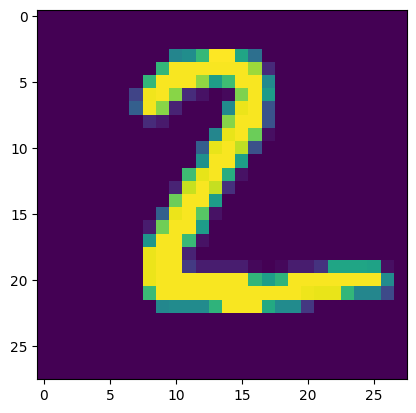

In [ ]:
plt.imshow(X_test[1])